# Lumped lake model equations 
- $\partial h_0/\partial t  = \frac{q_{in}-q_{out}}{LW}$ 
- $\partial h_s/\partial t = (D \pi/L) u_c $
- $\partial u_c/\partial t = -\pi g/L h_s - (\phi/D) u_c + \tau_c /(\rho D)$

In [9]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment

using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq, StaticArrays, Plots, JLD2, Random, Distributions

  Activating project at `c:\Users\david\OneDrive\Desktop\Studies\Delft\Internship\Julia\training_lake0d\Dataset`


# Normal data

In [10]:
# Model equations

# Forcing functions
function tau_c(t)  # wind stress [m^2/s^2] 
    x = 2π*t/(24*3600)
    return exp( sin(x) )* sin(x) + exp( sin( 2x ) ) * sin( 2x )
end

function q_in(t)
    return sin(2π*t/ (91.25*24*3600))*exp( sin(2π*t / (365*24*3600) ) )
end

function q_out(t)
    year = 365 * 24 * 3600
    return q_in(t-0.5year)
end

function lake_0d_b1(u, p, t)
	# compute f(x,p,t) for ode dx/dt=f(x,p,t)
    h0 = u
    L, W, D, g, phi, rho = p                            # unpack parameters
    dh0_dt = q_in(t)/(L*W) - q_out(t)/(L*W)             # change in mean water level due to inflow and outflow
    return  dh0_dt           # the @SVector creates a short-lived vector that's faster. 
end                                                     # It will work without, but a bit slower.

function lake_0d_b2(u, p, t)
	# compute f(x,p,t) for ode dx/dt=f(x,p,t)
    hs, uc = u
    L, W, D, g, phi, rho = p                            # unpack parameters
    dhs_dt = D*pi*uc/L                                  # change in surface slope 
    duc_dt = -g*pi*hs/L - phi*uc/D + tau_c(t)/(rho*D)   # change in velocity 
    return  @SVector [dhs_dt, duc_dt]           # the @SVector creates a short-lived vector that's faster. 
end                                                     # It will work without, but a bit slower.

lake_0d_b2 (generic function with 1 method)

In [8]:
# Setting up the problem

# Initial condition
u02 = @SVector [0, 0]  # initial condition: [mean water level, surface slope, velocity]
u01= 0

# Parameters
L=30.0e3                   # length of the domain [m]
W=L                        # width of the domain [m]
D=4.0                      # depth of the lake [m]
g=9.81                     # gravity [m/s^2]
phi=1.0e-4                 # friction parameter [m/s]
rho=1000.0                 # density of water [kg/m^3]
p=(L, W, D, g, phi, rho)   # parameters (not used in this case)

# Simulation parameters
t_end=24.0*3600.0  # end time [s]

prob1 = ODEProblem(lake_0d_b1, u01, (0.0, 2*365*t_end),p)
prob2 = ODEProblem(lake_0d_b2, u02, (0.0, 3*t_end),p)      # this is 2 year and 3 days, used to be a whole month 

sol1 = solve(prob1, Tsit5(), saveat = 12*3600) # every 12 hours
sol2 = solve(prob2, Tsit5(), saveat = 60*5) # every 5 minutes
nothing

In [11]:

# pyplot()
# # Plot results
# p1=plot(sol1.t./(24*3600), getindex.(sol1.u,1), xlabel="time [days]", xticks = 0:60:maximum(sol1.t)/(24*3600), legend=false, title="Mean water level in lake [m]")

# p2=plot(sol2.t./3600, getindex.(sol2.u,1), xlabel="time [hours]", xticks = 0:5:maximum(sol2.t)/(3600), legend=false, title="Surface slope in lake [m]")

# p3=plot(sol2.t./3600, getindex.(sol2.u,2), xlabel="time [hours]", xticks = 0:5:maximum(sol2.t)/(3600), legend=false, title="Velocity in lake [m/s]")

# d1 = plot(p1, layout=(1,1), size=(1200,300))
# d2 = plot(p2,p3, layout=(2,1), size=(1200,600))
# d3 = plot(p1,p2,p3, layout=(3,1), size=(1200,800))

# display(d1)
# display(d2)

# savefig(d1,"dataset1.png")
# savefig(d2,"dataset2.png")
# savefig(d3,"dataset3.png")

# # save the solution to a JLD2 file
# save("model_0d_lake_sep.jld2", 
#     "solution", (sol1.u, sol2.u) ,
#     "times", (sol1.t./3600, sol2.t./3600),
#     "tau", (tau_c.(sol1.t), tau_c.(sol2.t)),
#     "q_in", (q_in.(sol1.t), q_in.(sol2.t)),
#     "q_out", (q_out.(sol1.t), q_out.(sol2.t))
#     )

# Storm data

In [37]:
function tau_c(t;
               storms = [(2*24*3600,  5*3600, 2.0, 0.5, 5.0),   # (start, duration, intensity, gust amplitude, gust frequency)
                          (1*24*3600, 24*3600, 2.0, 0.3, 1.0)]) #  storms = [(2*24*3600,  15*3600, 4.0, 0.5, 7.0),
                                                                            #(1.5*24*3600, 12*3600, 3.0, 0.3, 10.0)])
    # Baseline daily wind cycle
    x = 2π * t / (24*3600)
    base = exp(sin(x))*sin(x) + exp(sin(2*x))*sin(2*x)

    # Sum of multiple storms
    storm_total = 0.0
    gust_total = 0.0

    for (t0, dur, int, gust_amp, gust_freq) in storms
        # Asymmetric shape parameters
        rise = dur / 6       # fast  rise  (~16% of storm)
        fall = dur / 2       # slow decay (~50% of storm)

        # Smooth asymmetric storm window using tanh
        rise_part = 0.5 * (1 + tanh((t - t0) / rise))
        fall_part = 0.5 * (1 - tanh((t - (t0 + dur)) / fall))
        window = rise_part * fall_part

        storm_total += int * window    
        
        # Add this storm contribution
        if window > 1e-3      # very small transitions excluded
            gust = gust_amp * (
                sin(gust_freq * x) +        # high-frequency oscillation
                0.2 * randn()               # turbulent micro-gust
            )
            gust_total += gust * window     # taper gust at edges
        end
    end

    return base + storm_total + gust_total
end

function q_in(t; storms = (1.5*365*24*3600, 10*24*3600, 5.0))
    x1 = 2π*t/(91.25*24*3600)
    x2 = 2π*t/(365*24*3600)
    base = sin(x1) * exp(sin(x2))

    t0, dur, amp = storms
    sigma_rise = dur / 2       # fast rise
    sigma_fall = dur / 2       # slower decay

    # Smooth asymmetric storm using tanh
    rise_part = 0.5 * (1 + tanh((t - t0)/sigma_rise))
    fall_part = 0.5 * (1 - tanh((t - (t0 + dur))/sigma_fall))
    window = rise_part * fall_part

    storm_total = amp * window

    return base + storm_total
end

function q_out(t; storms = (1.5*365*24*3600, 10*24*3600, 5.0))

    year = 365 * 24 * 3600
    return q_in(t - 0.5 * year; storms = storms)
end


prob1 = ODEProblem(lake_0d_b1, u01, (0.0, 3*365*t_end),p)
prob2 = ODEProblem(lake_0d_b2, u02, (0.0, 5*t_end),p)      # this is 3 year and 5 days

sol1 = solve(prob1, Tsit5(), saveat = 12*3600) # every 12 hours
sol2 = solve(prob2, Tsit5(), saveat = 60*5) # every 5 minutes
nothing


In [13]:
@show size(sol1)[1],size(sol2)[2]

((size(sol1))[1], (size(sol2))[2]) = (2191, 1441)


(2191, 1441)

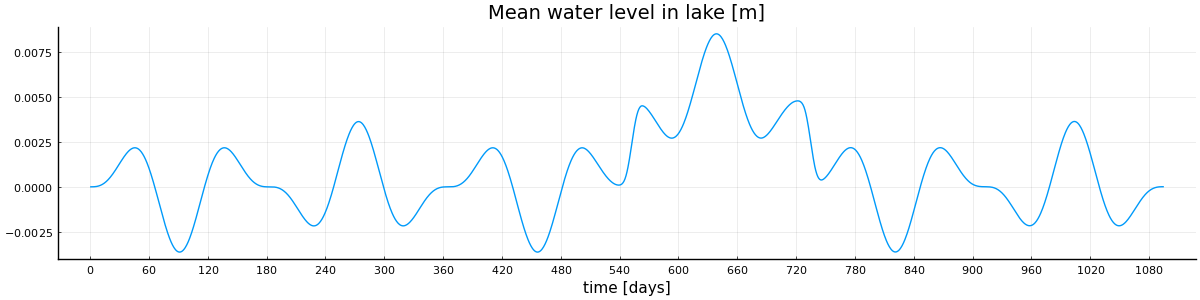

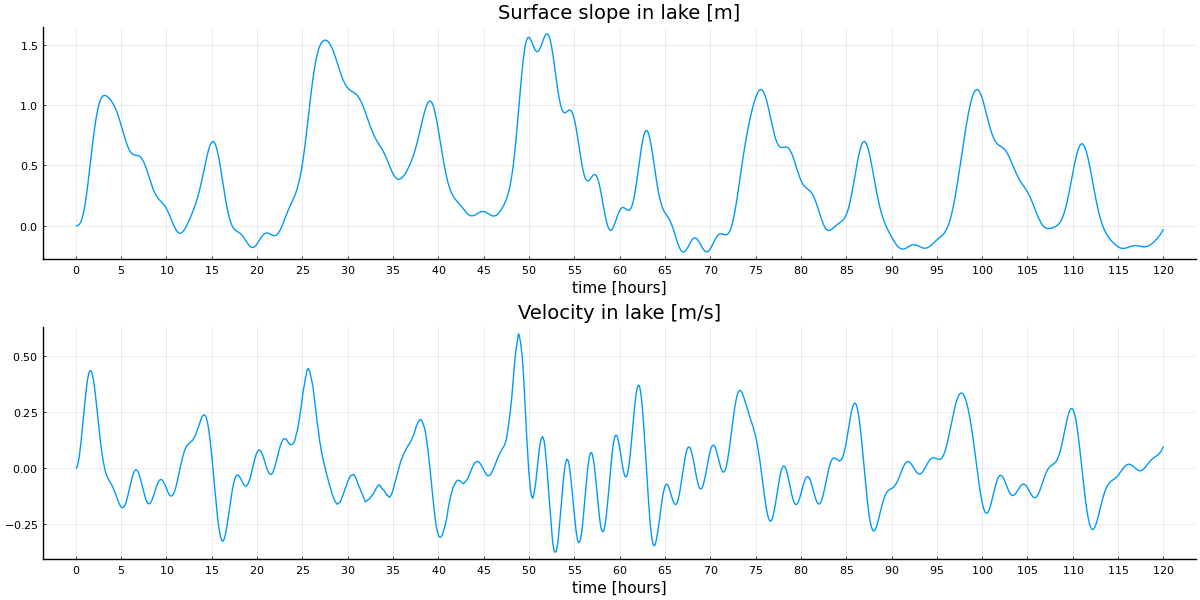

In [39]:

pyplot()
# Plot results
p1=plot(sol1.t./(24*3600), getindex.(sol1.u,1), xlabel="time [days]", xticks = 0:60:maximum(sol1.t)/(24*3600), legend=false, title="Mean water level in lake [m]")

p2=plot(sol2.t./3600, getindex.(sol2.u,1), xlabel="time [hours]", xticks = 0:5:maximum(sol2.t)/(3600), legend=false, title="Surface slope in lake [m]")

p3=plot(sol2.t./3600, getindex.(sol2.u,2), xlabel="time [hours]", xticks = 0:5:maximum(sol2.t)/(3600), legend=false, title="Velocity in lake [m/s]")

d1 = plot(p1, layout=(1,1), size=(1200,300))
d2 = plot(p2,p3, layout=(2,1), size=(1200,600))
d3 = plot(p1,p2,p3, layout=(3,1), size=(1200,800))

display(d1)
display(d2)

savefig(d1,"odd_3dataset1.png")
savefig(d2,"odd_3dataset2.png")
savefig(d3,"odd_3dataset3.png")
nothing

# save the solution to a JLD2 file
save("model_0d_lake_sep_odd3.jld2", 
    "solution", (sol1.u, sol2.u) ,
    "times", (sol1.t./3600, sol2.t./3600),
    "tau", (tau_c.(sol1.t), tau_c.(sol2.t)),
    "q_in", (q_in.(sol1.t), q_in.(sol2.t)),
    "q_out", (q_out.(sol1.t), q_out.(sol2.t))
    )
    

# Save

In [ ]:
# # save the solution to a JLD2 file
# save("model_0d_lake_sep.jld2", 
#     "solution", (sol1.u, sol2.u) ,
#     "times", (sol1.t./3600, sol2.t./3600),
#     "tau", (tau_c.(sol1.t), tau_c.(sol2.t)),
#     "q_in", (q_in.(sol1.t), q_in.(sol2.t)),
#     "q_out", (q_out.(sol1.t), q_out.(sol2.t))
#     )